In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
from utils.isomorphic import get_sub_graph_mapping_to_motif

In [3]:
# data = import_results('results/cook_si2_herm_chem_k3_m5.bin')
# data = import_results('results/pol_k3_m5.bin')
data = import_results('results/pol_k3_m10_new.bin')

# data = import_results('results/cmpx_pol_k3_m5.bin')
# data = import_results('results/cmpx_pol_k3_m10.bin')

# k = 4
# data = import_results('results/cook_si2_herm_chem_k4_m5.bin')
# data = import_results('results/durbin_herm_chem_k4_m5.bin')

# all: chem + gap
# data = import_results('results/cook_si2_herm_all_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)
# data = import_results('results/cook_si2_herm_gap_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)

# k =5
# data = import_results('results/cook_si2_herm_chem_k5_m10.bin')
# data = import_results('results/cook_si2_herm_all_k5_m10.bin')

# data = import_results('results/durbin_herm_chem_k3_m5.bin')

args = data['args']
motifs = data['motifs']

if args.input_network_file.startswith('../'):
    args.input_network_file = "/".join(args.input_network_file.strip("/").split('/')[1:])

network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table([m for m in motif.polarity_motifs if m.motif_criteria.is_motif != MotifType.none])

Network file name: s1_data.xlsx
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.757420091324201, '-': 0.2425799086757991})

Network properties:
	Neurons in the network: 283
	Participating Neurons (in the graph): 283

	Participating Nodes are neurons with at least: 10 synapses
	Synapses in the network: 11650
	Synapses in the graph: 7610
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 223
	Edges: 371
	Average clustering coefficient: 0.036
	Average shortest path (undirected): 1.875
	Density: 0.007
	Polarity ratios: Counter({'+': 0.8140161725067385, '-': 0.18598382749326145})
	Degree: Mean: 3.327 Std: 2.987 Median: 2.0 Max: 20 (node: RIAL)
	In-Degree: Mean: 1.664 Std: 2.668 Median: 0.0 Max: 15 (node: AVBR)
	Out-Degree: Mean: 1.664 Std: 1.607 Median: 1.0 Max: 10 (node: RIAL)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency t

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    total = sum(sizes)
    for s,l in zip(sizes, labels):
        print(f'{l}: {s}/{total}')

In [5]:
from matplotlib.patches import ArrowStyle 
as_ = ArrowStyle("simple", head_length=1.5, head_width=2.5, tail_width=.4)

def draw_motif(motif: Motif, ax):
    ax.axis('off')
    
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    ax.set_title(title, fontsize=7.5)

    graph = nx.DiGraph(motif.role_pattern)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax, arrowsize=5, arrowstyle=as_)
    # nx.draw_networkx(graph, pos, ax=ax, node_color='red', arrowsize=5, arrowstyle=as_)
    
    if motif.polarity:
        for role, pol in zip(motif.role_pattern, motif.polarity):
            s,t = role
            graph[s][t]['polarity'] = 'c' if pol == 'complex' else pol

        edge_labels=nx.get_edge_attributes(graph, 'polarity')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='k', font_weight='bold', label_pos=0.3)

In [6]:
def plot_motifs_z(motifs_list: list[Motif], motif_type: MotifType, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    figure = plt.figure()
    figure.set_size_inches(top, 4)
    
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)
    # plt.xticks(ids_, ids_, rotation='vertical')
    # plt.xticks([], [])

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2.25, 2))
    fig.set_size_inches(num_of_graphs*2.25, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        draw_motif(motif, ax_)

In [7]:
def plot_motif_roles(motif: Motif, top=5):
    roles = motif.node_roles.keys()
    num_of_rows = len(roles)
    if num_of_rows == 0:
        print(f'n_real: {motif.n_real}')
        return
    fig, ax = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(top, 4*num_of_rows))
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 

def get_polarity_index(motif: Motif, polarity: list[str]):
    pol_ids = [m.polarity for m in motif.polarity_motifs]
    return pol_ids.index(polarity)

In [8]:
def node_properties(node: Union[str, int], top=15):
    print(f'Node {node} properties:')
    
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    print(f'Degree: {network.graph.degree[node_idx]}')
    print(f'Out Degree: {network.graph.out_degree[node_idx]}')
    print(f'In Degree: {network.graph.in_degree[node_idx]}')
    print(f'Clustering coefficient: {round(nx.average_clustering(network.graph, nodes=[node_idx]), 3)}')

    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x:y for x,y in node_freq_in_motifs.items() if y!=0}
    
    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(top, 4))
    ax.set_title(f'Appearance of node: {node} in sub-graphs')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Sub-graph id')

    ax.bar(list(freq_sorted.keys())[:top], list(freq_sorted.values())[:top])
    # plt.show()

In [9]:
def get_motif_sub_graphs(motif: Motif, node = '', role = ''):
    motif_name = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 
    
    if node != "":
        print(f'Node "{node}" as role "{role}" - sub graphs in Motif {motif_name}:')
        node_idx = network.neuron_names.index(node) if isinstance(node, str) else node

    for sub_graph in motif.sub_graphs:
        role_nodes_mapping = get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern, motif.polarity)

        if role != '' and role_nodes_mapping[role] != node_idx:
            continue
            
        if network.neuron_names:
            role_nodes_mapping_w_neuron_names = {k:network.neuron_names[role_nodes_mapping[k]] for k in role_nodes_mapping}
        print(role_nodes_mapping_w_neuron_names)

In [10]:
def draw_sub_graph(neurons: list[str], center=None):
    node_list = [network.neuron_names.index(neuron) for neuron in neurons]

    induced_sub_graph = nx.induced_subgraph(network.graph, node_list)
    mapping = {i: n for i, n in enumerate(network.neuron_names)}
    graph = nx.relabel_nodes(induced_sub_graph, mapping)

    if len(graph.edges) == 0:
        print('empty graph')
        return
        
    pos = nx.circular_layout(graph)
    if center:
        pos[center] = np.array([0, 0])
    
    polarity = nx.get_edge_attributes(graph, 'polarity')
    synapse = nx.get_edge_attributes(graph, 'synapse')
    gap = nx.get_edge_attributes(graph, 'gap')

    widths = {}
    colors = []
    for edge in synapse:
        widths[edge] = synapse[edge] + gap[edge]
        if synapse[edge] > 0 and gap[edge] > 0:
            colors.append('black')
        elif synapse[edge] > 0:
            colors.append('blue')
        elif gap[edge] > 0:
            colors.append('red')
        else:
            print('err')

    width = list(widths.values())
    width_max = max(width)
    width = list(np.array(width) / width_max)

    # print(synapse)
    # print()
    # print(gap)

    for label in polarity:
        if polarity[label] == 'complex':
            polarity[label] = 'c'
        if polarity[label] == None:
            polarity[label] = ''

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    
    nx.draw_networkx(graph, pos=pos, ax=ax, node_size=600, node_color='lightgreen', width=width, edge_color=colors, connectionstyle="arc3,rad=0.1")

    nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax,
                                 edge_labels=polarity, font_color='k', font_weight='bold', label_pos=0.2)

def draw_neighbors(neuron: str):
    neighbors = [network.neuron_names[i] for i in list(network.graph.neighbors(network.neuron_names.index(neuron)))]
    neighbors.append(neuron)
    draw_sub_graph(neighbors, center=neuron)

In [11]:
# delete SIM subgraphs
# del_sims = []
# for m in motifs:
#     if not isinstance(m, int):
#         del_sims.append(m)

# for m in del_sims:
#     del motifs[m]
# print(f'deleted sim: {del_sims}')

motif: 5/12
anti-motif: 4/12
none: 3/12


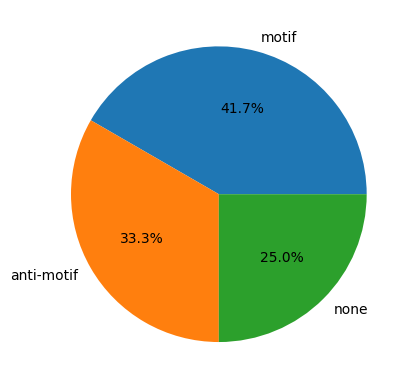

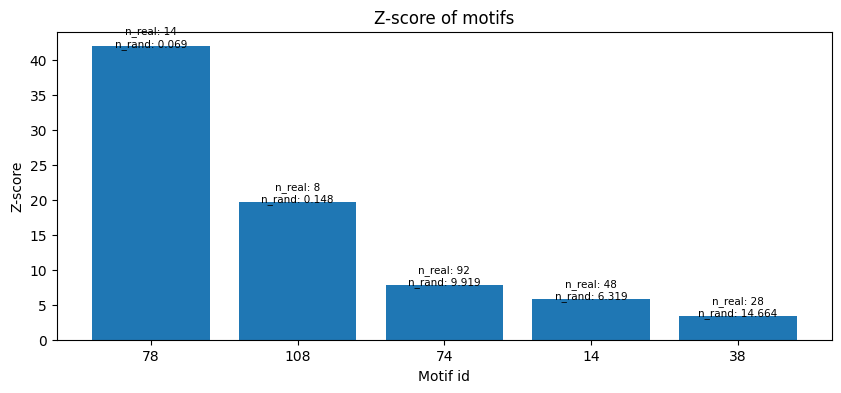

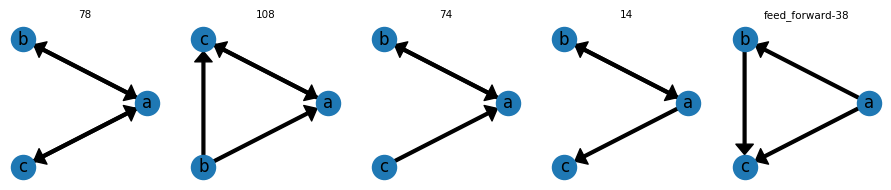

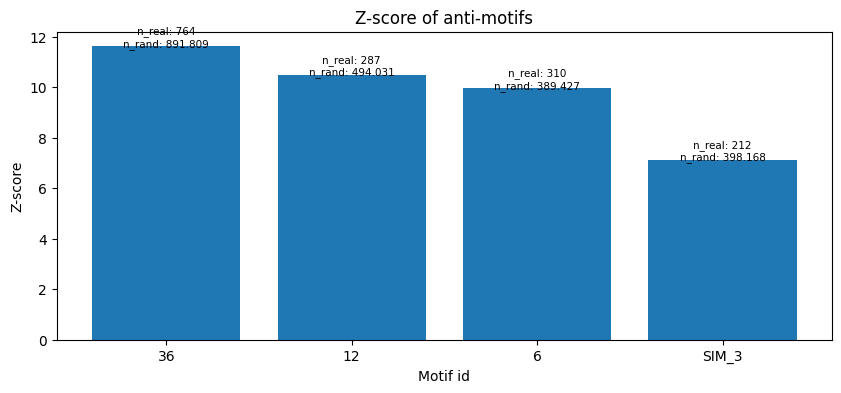

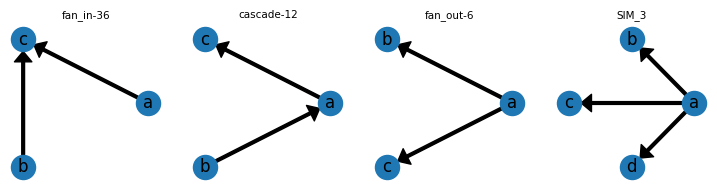

In [12]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]


motifs_ = [m for m in motifs_ if m.n_real > 1]
plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif, top=10)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=10)

In [13]:
# bi fan 204. bi parralel (diamond?) 904


Polarity

motif: 12/136
anti-motif: 6/136
none: 118/136


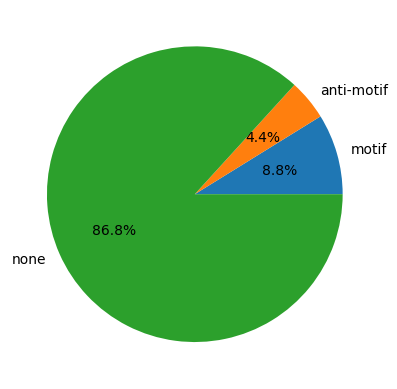

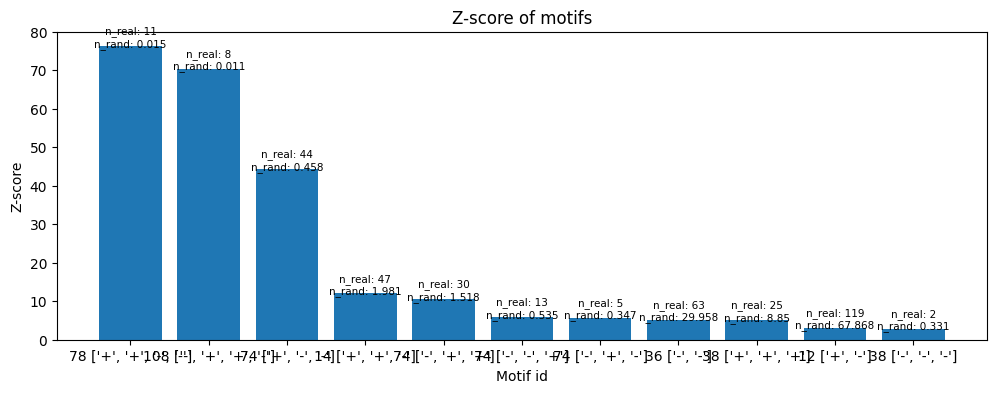

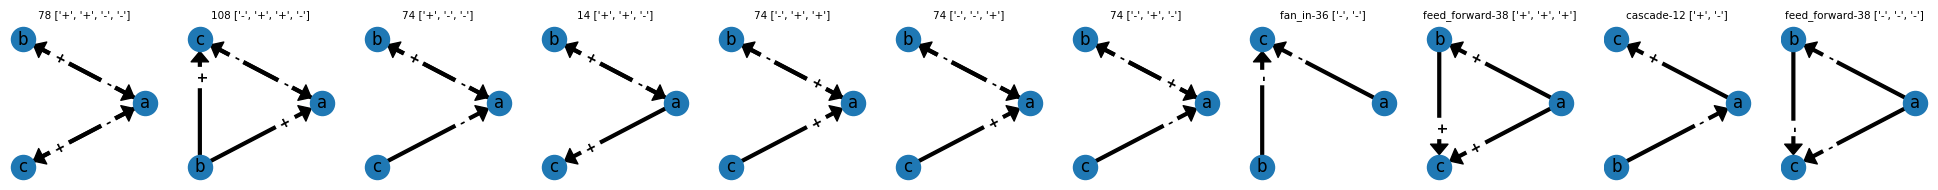

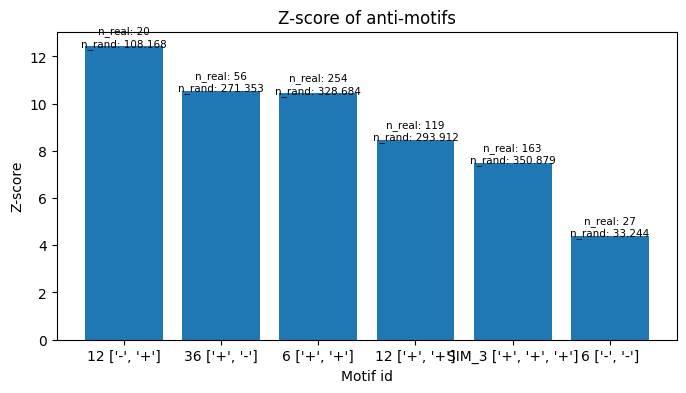

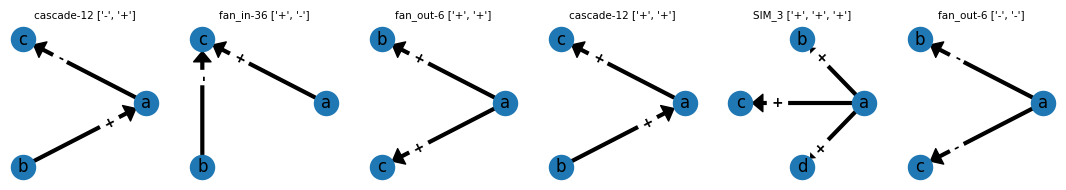

In [14]:
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)

motifs_ = [m for m in motifs_ if m.n_real > 1]
plot_motifs_z(motifs_, MotifType.motif, top=12)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=8)

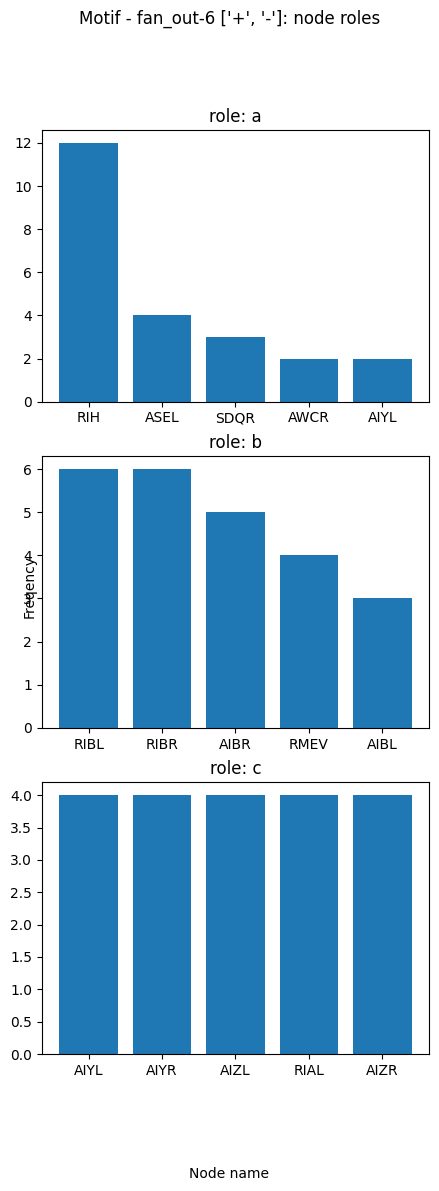

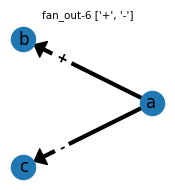

In [15]:
motif_ = motifs[6]
polarity = ['+', '-']
pol_idx = get_polarity_index(motif_, polarity)
plot_motif_roles(motif_.polarity_motifs[pol_idx])

{'a': 'ASEL', 'b': 'AIBL', 'c': 'AIYL'}
{'a': 'ASEL', 'b': 'AIBL', 'c': 'AIYR'}
{'a': 'ASEL', 'b': 'AIBR', 'c': 'AIYL'}
{'a': 'ASEL', 'b': 'AIBR', 'c': 'AIYR'}
{'a': 'ASER', 'b': 'AIBR', 'c': 'AIYR'}
{'a': 'AWCL', 'b': 'AIBL', 'c': 'AIYL'}
{'a': 'AWCR', 'b': 'AIBR', 'c': 'AIYL'}
{'a': 'AWCR', 'b': 'AIBR', 'c': 'AIYR'}
{'a': 'SDQR', 'b': 'AVBL', 'c': 'SMBVL'}
{'a': 'SDQR', 'b': 'AVBR', 'c': 'SMBVL'}
{'a': 'SDQR', 'b': 'DVA', 'c': 'SMBVL'}
{'a': 'URBL', 'b': 'IL1L', 'c': 'URXL'}
{'a': 'AIYL', 'c': 'AIZL', 'b': 'RIBL'}
{'a': 'AIYL', 'c': 'RIAL', 'b': 'RIBL'}
{'a': 'AIYR', 'c': 'AIZR', 'b': 'RIBR'}
{'a': 'AIYR', 'c': 'RIAR', 'b': 'RIBR'}
{'a': 'IL2L', 'c': 'RIH', 'b': 'RMER'}
{'a': 'RIH', 'c': 'AIZL', 'b': 'RIBL'}
{'a': 'RIH', 'c': 'AIZL', 'b': 'RIBR'}
{'a': 'RIH', 'c': 'AIZL', 'b': 'RMEV'}
{'a': 'RIH', 'c': 'AIZR', 'b': 'RIBL'}
{'a': 'RIH', 'c': 'AIZR', 'b': 'RIBR'}
{'a': 'RIH', 'c': 'AIZR', 'b': 'RMEV'}
{'a': 'RIH', 'c': 'RIAL', 'b': 'RIBL'}
{'a': 'RIH', 'c': 'RIAL', 'b': 'RIBR'}
{'a': '

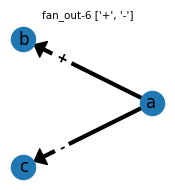

In [16]:
get_motif_sub_graphs(motif_.polarity_motifs[pol_idx])

In [17]:
motif_.polarity_motifs[pol_idx].sub_graphs

[((39, 12, {'polarity': '+'}), (39, 18, {'polarity': '-'})),
 ((39, 12, {'polarity': '+'}), (39, 19, {'polarity': '-'})),
 ((39, 13, {'polarity': '+'}), (39, 18, {'polarity': '-'})),
 ((39, 13, {'polarity': '+'}), (39, 19, {'polarity': '-'})),
 ((40, 13, {'polarity': '+'}), (40, 19, {'polarity': '-'})),
 ((72, 12, {'polarity': '+'}), (72, 18, {'polarity': '-'})),
 ((73, 13, {'polarity': '+'}), (73, 18, {'polarity': '-'})),
 ((73, 13, {'polarity': '+'}), (73, 19, {'polarity': '-'})),
 ((212, 53, {'polarity': '+'}), (212, 223, {'polarity': '-'})),
 ((212, 54, {'polarity': '+'}), (212, 223, {'polarity': '-'})),
 ((212, 103, {'polarity': '+'}), (212, 223, {'polarity': '-'})),
 ((233, 118, {'polarity': '+'}), (233, 235, {'polarity': '-'})),
 ((18, 20, {'polarity': '-'}), (18, 174, {'polarity': '+'})),
 ((18, 172, {'polarity': '-'}), (18, 174, {'polarity': '+'})),
 ((19, 21, {'polarity': '-'}), (19, 175, {'polarity': '+'})),
 ((19, 173, {'polarity': '-'}), (19, 175, {'polarity': '+'})),
 ((1

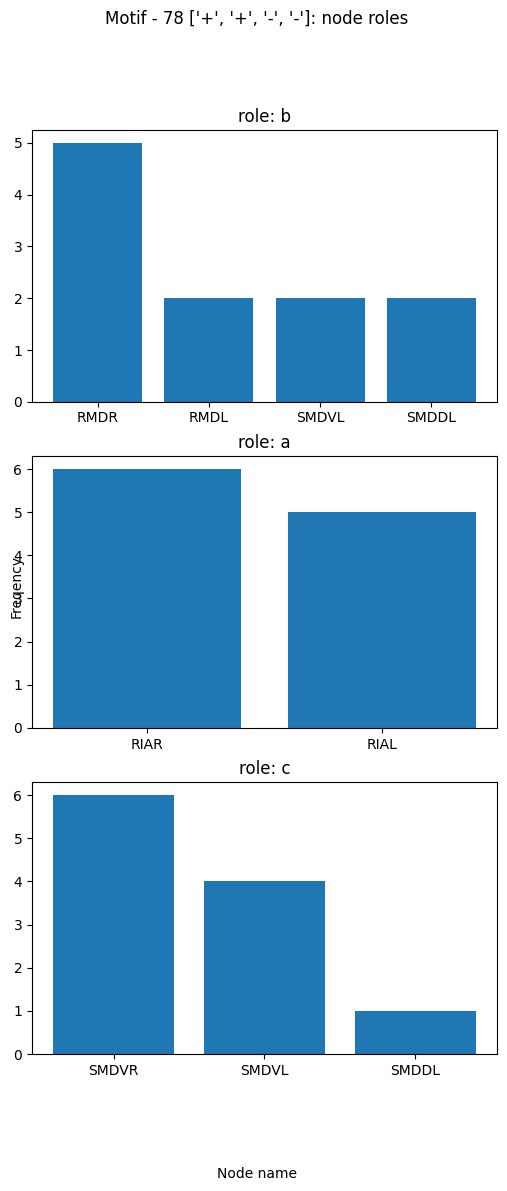

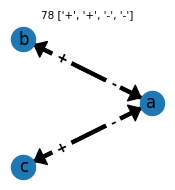

In [18]:
motif_ = motifs[78]
polarity = ['+', '+', '-', '-']
# polarity = ['complex', '-', 'complex', '+']
pol_idx = get_polarity_index(motif_, polarity)
plot_motif_roles(motif_.polarity_motifs[pol_idx], top=6)

{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVL'}
{'b': 'RMDR', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'SMDVL', 'a': 'RIAL', 'c': 'SMDVR'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDDL'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDVL'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDVR'}
{'b': 'SMDDL', 'a': 'RIAR', 'c': 'SMDVL'}
{'b': 'SMDDL', 'a': 'RIAR', 'c': 'SMDVR'}
{'b': 'SMDVL', 'a': 'RIAR', 'c': 'SMDVR'}


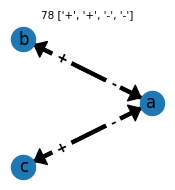

In [19]:
get_motif_sub_graphs(motif_.polarity_motifs[pol_idx])

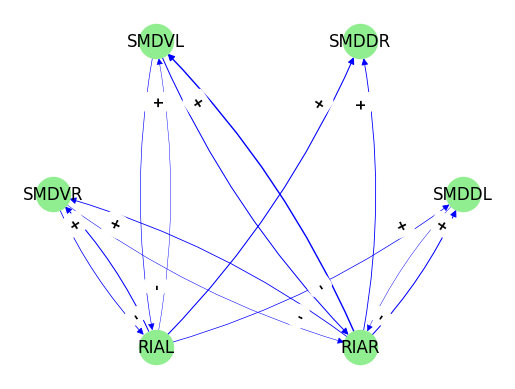

In [20]:
draw_sub_graph(['RIAL', 'SMDVL', 'SMDVR', 'SMDDL', 'SMDDR', 'RIAR'])

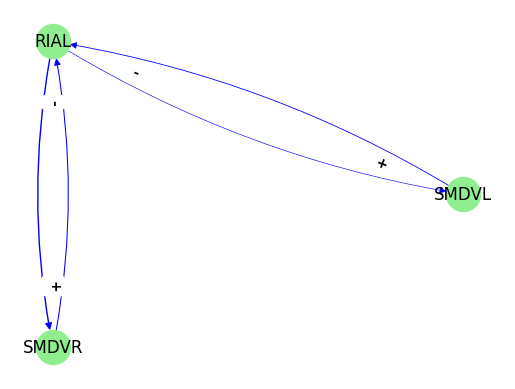

In [21]:
draw_sub_graph(['RIAL', 'SMDVL', 'SMDVR'])

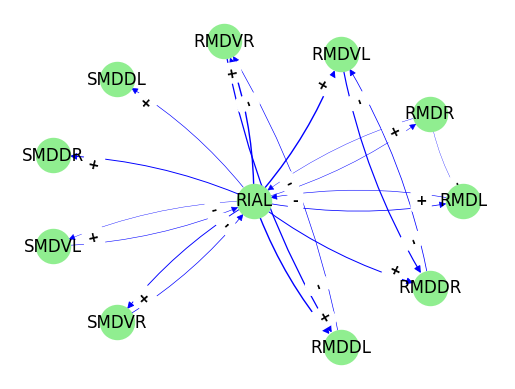

In [22]:
draw_neighbors('RIAL')

Node RIAL properties:
Degree: 20
Out Degree: 10
In Degree: 10
Clustering coefficient: 0.022


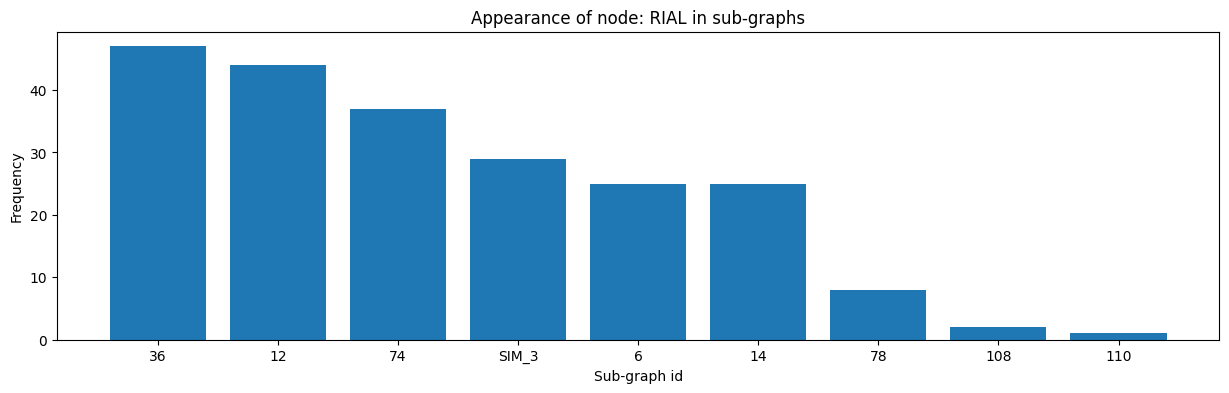

In [23]:
node_properties('RIAL')